[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SeoulTechPSE/EngNm/blob/master/ch11_code.ipynb)

In [ ]:
# Rendering sympy equations requires MathJax to be available within each cell output. 
# The following is a function that will make this happen for Colab.

#from IPython.display import Math, HTML
#
#def load_mathjax_in_cell_output():
#  display(HTML("<script src='https://www.gstatic.com/external_hosted/"
#               "mathjax/latest/MathJax.js?config=default'></script>"))
#get_ipython().events.register('pre_run_cell', load_mathjax_in_cell_output)

# Chapter 11: Partial differential equations

Creator: Robert Johansson, Updator: Kee-Youn Yoo

Updated source code listings for Numerical Python - A Practical Techniques Approach for Industry (ISBN 978-1-484205-54-9).

* Conceptually, the difference between ordinary and partial differential equations(PDEs) is not that big, but the computational techniques required to deal with ODEs and PDEs are very different, and solving PDEs is typically much more computationally demanding. Most techniques for solving PDEs numerically are based on the idea of discretizing the problem in each independent variable that occurs in the PDE, and thereby recasting the problem into an algebraic form. This usually results in <font color=blue>*very large-scale linear algebra problems*</font> 

* Two common techniques for recasting PDEs into algebraic form is the <font color=red> finite-difference methods (FDMs)</font>, where the derivatives in the problem are approximated with their finite-difference formula; and the <font color=red> finite-element methods (FEMs)</font>, where the unknown function is written as linear combination of simple basis functions that can be differentiated and integrated easily. The unknown function is described by a set of coefficients for the basis functions in this representation, and by a suitable rewriting of the PDEs, we can obtain algebraic equations for these coefficients

* With both FDMs and FEMs, the resulting algebraic equation system is usually very large, and in matrix 
form such equation systems are usually very sparse. Both FDM and FEM therefore heavily rely on sparse 
matrix representation for the algebraic linear equations. Most general-purpose 
frameworks for PDEs are based on FEM, or some variant thereof, as this method allows for solving very 
general problems on complicated problem domains.

* For Python, there are at least three significant libraries for solving PDE problems using the FEM method: [the FiPy library](https://www.ctcms.nist.gov/fipy/), [the SfePy library](http://sfepy.org/doc-devel/index.html), and [the FEniCS library](https://fenicsproject.org/). All of these libraries are extensive and feature rich. Here we can only give a brief introduction to PDE problems and survey prominent examples of PDE libraries that can be used from Python, and go through a few examples that illustrate some of the features of one of these libraries (FEniCS)

## Importing modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpl_toolkits.mplot3d

In [2]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg

## Partial differential equations

The unknown quantity in a PDE is a multivariate function, here denoted as $u$. In an 
$n$-dimensional problem, the function $u$ depends on $n$ independent variables: $u(x_1,x_2,\cdots,x_n)$.
A general PDE can formally be written as

$$
F \left( x_1, x_2, \cdots, x_n, \left\{ \frac{\partial u}{\partial x_{i_1}} \right\}_{ 0\leq i_1 \leq n}, \left\{ \frac{\partial^2 u}{\partial x_{i_1} x_{i_2}} \right\}_{ 0\leq i_1, i_2 \leq n}, \cdots  \right) = 0, \;\;\mathbf{x} \in \Omega
$$

where $\Omega$ is the domain of the PDE problem. Many PDEs that occur in practice only 
contain up to second-order derivatives, and we typically deal with problems in two or three spatial 
dimensions, and possibly time. 

When working with PDEs, it is common to denote the partial derivatives with respect to an independent variable using the subscript notation: $\displaystyle u_x = \frac{\partial u}{\partial x}$, $\displaystyle u_{xx} = \frac{\partial^2 u}{\partial^2 x}$, $\displaystyle u_{xy} = \frac{\partial^2 u}{\partial x \partial y}$ and so on.

* To fully specify a particular solution to a PDE, we need to define its boundary conditions, which are the known values of $u$ or the specific combinations of $u$ and its derivatives along the boundary of the problem domain $\Omega$, as well as the initial values if the problem is time dependent. The boundary is often denoted as $\Gamma$ or $\partial \Omega$, and in general different boundary conditions can be given for different parts of the boundary

* Three important types of boundary conditions are 
 
 * *Dirichlet boundary condition*, which specifies the value of the function at the boundary, 
 
   $\displaystyle u(\mathbf{x}) = g(\mathbf{x})$ for $\mathbf{x} \in \Gamma_D$ 
 
 * *Neumann boundary condition*, which specifies the normal derivative on the boundary, 
 
   $\displaystyle \frac{\partial u}{\partial \mathbf{n}} = h(\mathbf{x})$ for $\mathbf{x} \in \Gamma_N$,  where the $\mathbf{n}$ is the outward normal from the boundary
 
 * *Robin boundary condition*, which specifies as follows: $\displaystyle \alpha u(\mathbf{x}) +\beta \frac{\partial u}{\partial \mathbf{n}} = f(\mathbf{x})$ for $\mathbf{x} \in \Gamma_R$.

## Finite-difference methods 

The basic idea of the finite-difference method is to approximate the derivatives that occur in a differential equation with their finite-difference formulas on a discretized space. Replacing derivatives in an ODE or PDE with their finite-difference formulas recasts the problem from a differential equation to algebraic equations. If the original ODE or PDE is linear, the algebraic equations are also linear, and can be solved with standard linear algebra methods.

### 1-dimensional

Consider the ODE problem $u_{xx} = -5$ in the interval $x \in [0,\;1]$, and with boundary conditions 
$u(x=0) = 1$ and $u(x=1) =2$, which, for example, arises from the steady-state heat 
equation in one dimension. In contrast to the initial-value problem considered, this is a boundary-value problem because the values of $u$ are specified at both $x=0$ and $x=1$.

We can treat this problem by dividing the interval $[0,\; 1]$ into interior discrete points $x_i, \,i=1,2,\cdots, N$, and the problem is then to find the function $u(x_i) = u_i$ at these points. 
Writing the ODE problem in finite-difference form gives an equation 


$$
\frac{u_{i-1} -2u_i +u_{i +1}}{(\Delta x)^2} = -5
$$

for every interior point $x_i$, with the boundary conditions $u_0 = 1$ and $u_{N+1}=2$.
Here the interval $[0,\; 1]$ is discretized into $N+2$ evenly spaced points, including the boundary points, with separation $\Delta x = 1/(N+1)$.

The set of equations for the interior points can be written 
in a matrix form as $\mathbf{Au} =\mathbf{b}$, where

$$
\mathbf{A} = \frac{1}{(\Delta x)^2} 
\begin{bmatrix}
-2 & 1 & 0 & \cdots& \cdots\\ 
1 & -2  & 1 & \ddots &  \ddots\\ 
0 & 1 & -2 & 1 & \ddots & \\ 
\vdots & \ddots & \ddots & \ddots &\ddots \\ 
\vdots & \ddots & \ddots & 1 & -2
\end{bmatrix},\;
\mathbf{b} = \begin{bmatrix}
 -\left(5 +\frac{u_0}{(\Delta x)^2}\right),&  -5, & \cdots, & -5, &  -\left(5 +\frac{u_{N+1}}{(\Delta x)^2} \right)
\end{bmatrix}^T
$$

Here the matrix $\mathbf{A}$ describes the coupling of the equations for $u_i$ to values at neighboring points due to the 
finite-difference formula that was used to approximate the second-order derivative in the ODE. The boundary 
values are included in the $\mathbf{b}$ vector, which also contains the constant right-hand side of the original ODE 
(the source term). 

At this point we can straightforwardly solve the linear equation system $\mathbf{Au} = \mathbf{b}$ for the 
unknown vector of $\mathbf{u}$ and thereby obtain the approximate values of the function $u(x)$ at the discete points $\{
x_i\}$.

In [3]:
N = 5
x = np.linspace(0, 1, N +2); dx = 1.0 /(N + 1)

A = (np.eye(N, k=-1) -2 *np.eye(N) +np.eye(N, k=1)) /dx**2; A

array([[-72.,  36.,   0.,   0.,   0.],
       [ 36., -72.,  36.,   0.,   0.],
       [  0.,  36., -72.,  36.,   0.],
       [  0.,   0.,  36., -72.,  36.],
       [  0.,   0.,   0.,  36., -72.]])

In [4]:
u0 = 1
u1 = 2

b = -5 *np.ones(N); b[0] -= u0 /dx**2; b[N-1] -= u1 /dx**2; b

array([-41.,  -5.,  -5.,  -5., -77.])

In [5]:
u = np.linalg.solve(A, b); U = np.hstack([u0, u, u1])

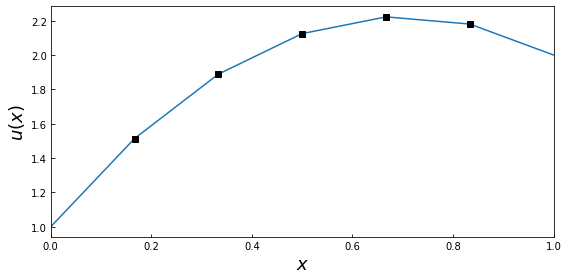

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(x, U)
ax.plot(x[1:-1], u, 'ks')
ax.set_xlim(0, 1)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$u(x)$", fontsize=18)
ax.tick_params(which='both', direction='in')

fig.tight_layout();

### 2-dimensional

Consider the following two-dimensional generalization of the previous problem: $u_{xx} +u_{yy} = 0$, with the boundary conditions $u(x=0)=3$, $u(x=1)=-1$, $u(y=0)=-5$, and $u(y=1) = 5$ (no source term). In finite-difference form, we can write the PDE as
 
$$
\frac{u_{m-1,n} -2u_{m,n} +u_{m+1,n}}{(\Delta x)^2} +\frac{u_{m, n-1} -2u_{m,n} +u_{m,n+1}}{(\Delta y)^2}=0
$$

If we divide the $x$ and $y$ intervals into $N$ interior points ($N+2$ points including the boundary points), then $\Delta x = \Delta y = \frac{1}{N+1}$, and $\mathbf{u}$ is a $N \times N$ matrix. To write the equation on the standard form $\mathbf{Av}= \mathbf{b}$, we can rearrange the matrix $\mathbf{u}$ by stacking its columns(or raws) into a vector of size $N^2 \times 1$

$$
\frac{v_{m-1 + N n} - 2v_{m + N n} + v_{m+1 + N n}}{(\Delta x)^2}
+\frac{v_{m + N (n-1)} - 2v_{m + Nn} + v_{m + N(n+1)}}{(\Delta y)^2}
= 0
$$

The matrix $\mathbf{A}$ is then of size $N^2 \times N^2$, which can be very big if we need to use a 
fine discretization of the $x$ and $y$ coordinates. Fortunately, since the finite-difference formula only couples neighboring points, the matrix $\mathbf{A}$ turns out to be very sparse, 
and here we can benefit greatly from working with sparse matrices, as we will see in the following

In [7]:
u0_l, u0_r = 3, -1
u0_t, u0_b = 5, -5

N = 100
dx = 1 /(N +1)

Because the finite-difference formula couples both neighboring 
rows and columns, it is slightly more involved to construct the matrix $\mathbf{A}$ for this example. 
However, a relatively direct approach is to first define the matrix 
`A_1d` that corresponds to the one-dimensional formula 
along one of the coordinates (say $x$, or the index $m$ in $u_{m,n}$).

In [9]:
A_1d = (sp.eye(N, k=-1) +sp.eye(N, k=1) -4 *sp.eye(N)) /dx**2

To distribute this formula along each row, we can take the tensor product of the identity matrix of size 
$N\times N$ with the `A_1d` matrix. The result describes all derivatives along the $m$-index for all values indices $n$. To cover the terms that couple the equation for $u_{m,n}$ to $u_{m,n+1}$ and $u_{m,n-1}$, that is the derivatives along the index $n$, we need to add diagonals that are separated from the main diagonal by $N$ positions

In [10]:
A = sp.kron(sp.eye(N), A_1d) +(sp.eye(N**2, k=-N) +sp.eye(N**2, k=N)) /dx**2; A

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 49600 stored elements in Compressed Sparse Row format>

The printout of $\mathbf{A}$ shows that it is a sparse matrix with $10^8$ elements with $49600$ nonzero elements, so 
that only one out of about 2000 elements is nonzero, and $\mathbf{A}$ is indeed very sparse. 

To construct the vector $\mathbf{b}$ from the boundary conditions, it is convenient to create a 
$N \times N$ array of zeros, and assign the boundary condition to edge elements of this array
 (which are the corresponding elements in $u$ that are coupled to the 
boundaries, that is, the interior points that are neighbors to the boundary). Once this 
$N \times N$ array is created and assigned, we can use the `reshape` method to rearrange it into a 
$N^2 \times 1$ vector that can be used in the $\mathbf{Av} = \mathbf{b}$:

In [12]:
b = np.zeros((N, N))

b[0, :]  += u0_b 
b[-1, :] += u0_t
b[:, 0]  += u0_l
b[:, -1] += u0_r

b = -b.reshape(N**2) /dx**2; b

array([ 20402.,  51005.,  51005., ..., -51005., -51005., -40804.])

When the $\mathbf{A}$ and $\mathbf{b}$ arrays are created, we can proceed to solve the equation system for the vector 
$\mathbf{v}$, and use the `reshape` method to arrange it back into the $N \times N$ matrix $\mathbf{u}$. 

In [13]:
v = sp.linalg.spsolve(A, b)
u = v.reshape(N, N)

---

In [12]:
U = np.vstack([np.ones((1, N +2)) * u0_b,
               np.hstack([np.ones((N, 1))*u0_l, u, np.ones((N, 1))*u0_r]),
               np.ones((1, N +2)) * u0_t])

x = np.linspace(0, 1, N+2)
X, Y = np.meshgrid(x, x)

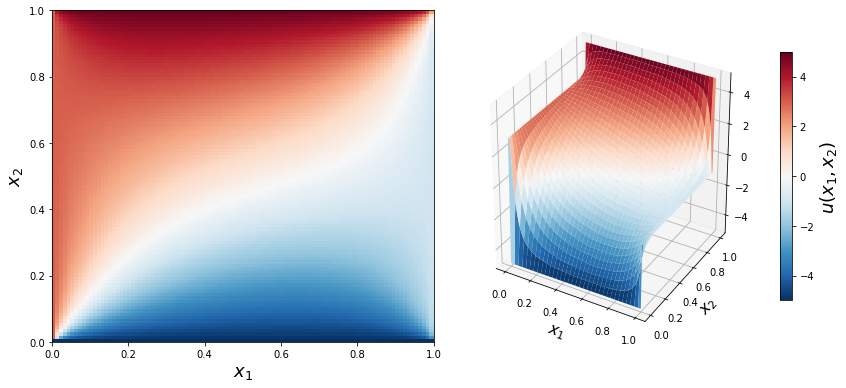

In [13]:
fig = plt.figure(figsize=(12, 5.5))
cmap = mpl.cm.get_cmap('RdBu_r')

#---------------------------------------------
ax = fig.add_subplot(1, 2, 1)

p = ax.pcolor(X, Y, U, vmin=-5, vmax=5, cmap=cmap)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)


#---------------------------------------------
ax = fig.add_subplot(1, 2, 2, projection='3d')

p = ax.plot_surface(X, Y, U, vmin=-5, vmax=5, rstride=3, cstride=3, linewidth=0, cmap=cmap)
ax.set_xlabel(r"$x_1$", fontsize=16)
ax.set_ylabel(r"$x_2$", fontsize=16)

cb = plt.colorbar(p, ax=ax, shrink=0.75)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)

fig.tight_layout()

To illustrate in concrete terms the importance of using sparse 
matrices for this type of problems, we can compare the time required for solving of the 
$\mathbf{Av} = \mathbf{b}$ equation: 

In [14]:
A_dense = A.todense()

In [15]:
%time np.linalg.solve(A_dense, b)

CPU times: user 1min 59s, sys: 1.63 s, total: 2min 1s
Wall time: 2min


array([-0.99935633, -2.57993459, -3.32295674, ...,  3.74173632,
        3.18462949,  1.99935633])

In [16]:
%time la.solve(A_dense, b)

CPU times: user 2min 9s, sys: 1.22 s, total: 2min 10s
Wall time: 2min 10s


array([-0.99935633, -2.57993459, -3.32295674, ...,  3.74173632,
        3.18462949,  1.99935633])

In [17]:
%time sp.linalg.spsolve(A, b)

CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 85.2 ms


array([-0.99935633, -2.57993459, -3.32295674, ...,  3.74173632,
        3.18462949,  1.99935633])

From these results, we see that using sparse matrices for the present problem results in a speedup of 
several orders of magnitude.

The finite-difference method that we used in the last two examples is powerful and relatively simple 
method for solving ODE boundary-value problems and PDE problems with simple geometries. However, it 
is not so easily adapted to problems on more complicate domains, or problems on nonuniform coordinate 
grids. For such problems finite-element methods are typically more flexible and convenient to work with, 
and although FEMs are conceptually more complicated than FDMs, they can be computationally efficient 
and adapts well to complicated problem domains and more involved boundary conditions.

### 2-dimensional with source term

In [18]:
b = - np.ones((N, N)).reshape(N**2)
u = sp.linalg.spsolve(A, b).reshape(N, N)

In [19]:
U = np.vstack([np.zeros((1, N +2)),
               np.hstack([np.zeros((N, 1)), u, np.zeros((N, 1))]),
               np.zeros((1, N +2))])

x = np.linspace(0, 1, N +2)
X, Y = np.meshgrid(x, x)

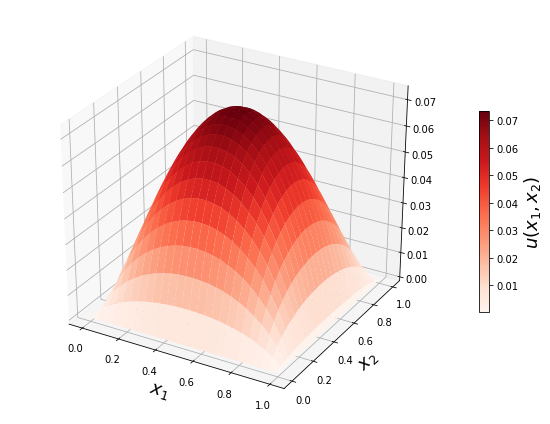

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={'projection': '3d'})

p = ax.plot_surface(X, Y, U, rstride=4, cstride=4, linewidth=0, cmap=mpl.cm.get_cmap("Reds"))
cb = fig.colorbar(p, shrink=0.5)

ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)

fig.tight_layout()

## Finite-element methods

The basic idea of this method is to represent the domain on which the PDE is defined with a finite 
set of discrete regions, or elements, and to approximate the unknown function as a linear combination of 
basis functions with local support on each of these elements (or on a small group of neighboring elements). 
Mathematically, this approximation solution, $u_h$, represents a projection of the exact solution 
$u$ in the function space $V$ (for example, continuous real-valued functions) onto a finite subspace 
$V_h \subset V$ that is related to the discretization of the problem domain. If $V_h$ is a suitable subspace of 
$V$, then it can be expected that $u_h$ can be a good approximation to $u$.

To be able to solve the approximate problem on the simplified function space $V_h$, we can first rewrite the 
PDE from its original formulation, which is known as the *strong form*, to its corresponding variational form, 
also known as the *weak form*. To obtain the weak form we multiply the PDE with an arbitrary function $v$
 and integrate over the entire problem domain. The function $v$  is called a *test function*, and it can in general be 
defined on function space $\hat{V}$ that differs from that of $u$, which in this context is called a 
*trial function*.

For example, consider the steady-state heat equation (also known as the Poisson equation) that we
solved using the FDM earlier in this chapter: The strong form of this equation is $-\Delta u(\mathbf{x}) = f(\mathbf{x})$ , where we
have used the vector operator notation. By multiplying this equation with a test function $v$ and integrating
over the domain $\mathbf{x} \in \Omega$ we obtain the weak form:

$$
-\int_{\Omega} \Delta u \, v\, d\mathbf{x} = \int_\Omega f \,v \,d\mathbf{x}
$$

Since the exact solution $u$ satisfies the strong form, it also satisfies the weak form of the PDE for any
reasonable choice of $v$. The reverse does not necessarily hold true, but if a function $u_h$ satisfies the weak form
for a large class of suitably chosen test functions $v$, then it is plausible that it is a good approximation to the
exact solution $u$ (hence the name test function).

To treat this problem numerically, we first need to make the transition from the infinite-dimensional
function spaces $V$ and $\hat{V}$ to approximate finite-dimensional function spaces $V_h$ and $\hat{V}_h$ :

$$
-\int_{\Omega} \Delta u_h \, v_h\, d\mathbf{x} = \int_\Omega f \,v_h \,d\mathbf{x}
$$

where $u_h \in V_h$ and $v_h \in  \hat{V}_h$. The key point here is that $V_h$ and $\hat{V}_h$ are finite dimensional, so we can use
a finite set of basis functions ${\phi_j}$ and ${\hat{\phi}_i}$ that spans the function spaces $V_h$ and $\hat{V}_h$ respectively, to describe the functions $u_h$ and $v_h$. In particular, we can express $u_h$ as a linear combination of the basis functions that
spans its function space, $u_h =\sum U_j \phi_j$. Inserting this linear combination in the weak form of the PDE and
carrying out the integrals and differential operators on the basis functions, instead of directly over terms in
the PDE, yields a set of algebraic equations.

To obtain an equation system on the simple form $\mathbf{AU} = \mathbf{b}$ , we also must write the weak form of the
PDE on bilinear form with respect to the $u_h$ and $v_h$ functions: $a(u_h, v_h) =L(v_h)$ for some functions $a$ and $L$. This is not always possible, but for the current example of the Poission equation we can obtain this form by
integrating by parts:

$$
-\int_\Omega \Delta u_h\, v_h \, d\mathbf{x} 
= \int_\Omega \nabla u_h \cdot \nabla v_h \,d\mathbf{x} -\int_\Omega \nabla \cdot (\nabla u_h v_h) \,d\mathbf{x}
= \int_\Omega \nabla u_h \cdot \nabla v_h \,d\mathbf{x} -\int_{\partial \Omega} (\nabla u_h \cdot \mathbf{n}) v_h\, d\Gamma
$$

where in the second equality we have also applied Gauss theorem to convert the second term to an integral
over the boundary $\partial \Omega$ of the domain $\Omega$. Here $\mathbf{n}$ is the outward normal vector of the boundary $\partial \Omega$. There is no general method for rewriting a PDE on strong form to weak form, and each problem will have to be
approached on a case-by-case basis.

To this end, assume that the problem satisfies the Dirichlet boundary condition on a part of $\partial \Omega$ denoted $\Gamma_D$, Neumann boundary conditions on another part of  $\partial \Omega$ denoted $\Gamma_N$, and Robin boundary conditions on the remaining part of  $\partial \Omega$ denoted $\Gamma_R$: $\{u=u_D,\;\mathbf{x} \in \Gamma_D \}$, $\{\nabla u \cdot \mathbf{n}=g,\;\mathbf{x} \in \Gamma_N \}$,  $\{\nabla u \cdot \mathbf{n}=r(u -s),\;\mathbf{x} \in \Gamma_R \}$. Since we are free to choose the test functions $v_h$, we can let $v_h$ vanish on the part of the boundary that satisfies Dirichlet boundary conditions. In this case we obtain the following weak form of the PDE problem:

$$
\int_\Omega \nabla u_h \cdot \nabla v_h \,d\mathbf{x} -\int_{\Gamma_R} r u_h\, v_h\, d\Gamma=\int_\Omega f\, v_h \,d\mathbf{x} +\int_{\Gamma_N} g v_h\, d\Gamma
-\int_{\Gamma_R} r \,s\, v_h\, d\Gamma
$$

If we substitute the function $u_h$ for its expression as a linear combination of basis functions, and
substitute the test function with one of its basis functions, we obtain an algebraic equation:

$$
\sum_j U_j \left(\int_\Omega \nabla \phi_j \cdot \nabla \hat{\phi}_i \,d\mathbf{x} -\int_{\Gamma_R} r \phi_j\, \hat{\phi}_i \,d\Gamma \right)
=\int_\Omega f\, \hat{\phi}_i \,d\mathbf{x} +\int_{\Gamma_N} g \hat{\phi}_i\, d\Gamma
-\int_{\Gamma_R} r \,s\, \hat{\phi}_i\, d\Gamma
$$

If there are $N$ basis functions in $V_h$, then there are $N$ unknown coefficients $U_j$, and we need $N$ independent
test functions $\hat{\phi}_i$ to obtain a closed equation system. This equation system is on the form $\mathbf{AU} = \mathbf{b}$ with
$A_{ij}=\int_\Omega \nabla \phi_j \cdot \nabla \hat{\phi}_i \,d\mathbf{x} -\int_{\Gamma_R} r \phi_j\, \hat{\phi}_i \,d\Gamma$
and $b_i=\int_\Omega f\, \hat{\phi}_i \,d\mathbf{x} +\int_{\Gamma_N} g \hat{\phi}_i\, d\Gamma
-\int_{\Gamma_R} r \,s\, \hat{\phi}_i\, d\Gamma$. Following this procedure we have therefore converted the
PDE problem into a system of linear equations that can be readily solved.

In practice, a very large number of basis functions can be required to obtain a good approximation
to the exact solution, and the linear equation systems generated by FEMs are therefore often very large.
However, the fact that each basis functions have support only at one or a few nearby elements in the
discretization of the problem domain ensures that the matrix $\mathbf{A}$ is sparse, which makes it tractable to solve
rather large-scale FEM problems. We also note that an important property of the basis functions $\phi_j$ and $\hat{\phi}_i$
is that it should be easy to compute the derivatives and integrals of the expression that occur in the final
weak form of the problem, so that the matrix $\mathbf{A}$ and vector $\mathbf{b}$ can be assembled efficiently.

When using FEM software for solving PDE problems, it is typically required to convert the PDE to weak
form by hand, and if possible rewrite it on the bilinear form $a(u,v) = L(v)$ . It is also necessary to provide a
suitable discretization of the problem domain. This discretization is called a mesh, and it is usually made up
of triangular partitioning (or their higher-order generalizations) of the total domain. Meshing an intricate
problem domain can in itself be a complicated process, and it may require using sophisticated software
especially dedicated for mesh generation. For simple geometries there are tools for programmatically
generating meshes, and we will see examples of this in the following section.

Once a mesh is generated and the PDE problem is written on a suitable weak form, we can feed the
problem into a FEM framework, which then automatically assembles the algebraic equation system and
applies suitable sparse equation solvers to find the solution. In this processes, we often have a choice of what
type of basis functions to use, as well as which type of solver to use. Once the algebraic equation is solved,
we can construct the approximation solution to the PDE with the help of the basis functions, and we can for
example visualize the solution or post process it in some other fashion.

In the following section, we will look at solving example problems with **FEniCS**, and thereby introduce some
of its basic features and usage. The hope is that the examples can give a flavor of how it is to work with FEM
problems in Python, and provide a starting point for the readers interested in learning more about FEM
with Python.


## Solving PDEs using FEniCS

FEniCS is a highly capable FEM framework that is made up of a collection of libraries and tools for
solving PDE problem. Much of FEniCS is programmed in C++, but it also provides an official Python interface.
Because of the complexity of the many dependencies of the FEniCS libraries to external low-level numerical
libraries, FEniCS is usually packaged and installed as an independent environment. For more information about
the FEniCS, see the project's web site at http://fenicsproject.org. At the time of writing, the most recent
version is 2017.1.0.

### FEniCS on Docker and Jupyter Notebook

    $ docker version
    Client:
     Version:      17.03.1-ce
     API version:  1.27
     Go version:   go1.7.5
     Git commit:   c6d412e
     Built:        Tue Mar 28 00:40:02 2017
     OS/Arch:      windows/amd64

    Server:
     Version:      17.03.1-ce
     API version:  1.27 (minimum version 1.12)
     Go version:   go1.7.5
     Git commit:   c6d412e
     Built:        Fri Mar 24 00:00:50 2017
     OS/Arch:      linux/amd64
     Experimental: true

    $ docker pull quay.io/fenicsproject/stable:latest
    
    $ docker run --name fenics-notebook -w /home/fenics/shared -v ${pwd}:/home/fenics/shared -d -p 127.0.0.1:8888:8888 quay.io/fenicsproject/stable 'jupyter-notebook --ip=0.0.0.0'
    
    $ docker logs --tail 3 fenics-notebook
    Copy/paste this URL into your browser when you connect for the first time,
    to login with a token:
        http://0.0.0.0:8888/?token=e720c81a3a3cc44ff55a8f2f92f86e2512d24467f233a9f7

### Solving the Possion equation

$$
\begin{eqnarray}
-\Delta u(\mathbf{x}) &&= f(\mathbf{x}),\:&&\mathbf{x} \:\text{in} \:\Omega \\ 
u(\mathbf{x}) &&= u_D(\mathbf{x}),\:&&\mathbf{x} \:\text{on} \:\partial\Omega 
\end{eqnarray}
$$

In [1]:
"""
FEniCS tutorial demo program: Poisson equation with Dirichlet conditions.
Test problem is chosen to give an exact solution at all nodes of the mesh.
  -Laplace(u) = f    in the unit square
            u = u_D  on the boundary
  u_D = 1 + x^2 + 2y^2
    f = -6
"""

from __future__ import print_function
from fenics import *
import numpy as np

In [2]:
# Create mesh and define function space
mesh = UnitSquareMesh(8, 8)
V = FunctionSpace(mesh, 'P', 1)

In [3]:
# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

In [4]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(-6.0)
a = dot(grad(u), grad(v))*dx
L = f*v*dx

In [5]:
# Compute solution
u = Function(V)
solve(a == L, u, bc)

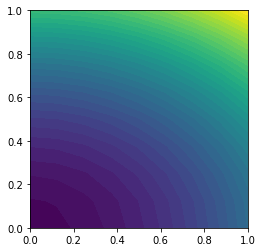

In [8]:
# Plot solution
plot(u);

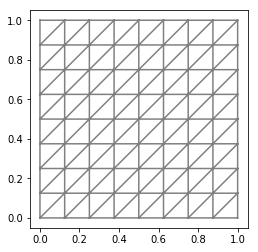

In [9]:
plot(mesh);

In [2]:
from IPython.display import HTML

In [4]:
HTML(X3DOM().html(u))

NameError: name 'X3DOM' is not defined

In [12]:
# Compute error in L2 norm
error_L2 = errornorm(u_D, u, 'L2')

# Compute maximum error at vertices
vertex_values_u_D = u_D.compute_vertex_values(mesh) # see pp.28-29 "of The FEniCS Tutorial Volum I
vertex_values_u = u.compute_vertex_values(mesh)
error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# Print errors
print('error_L2  =', error_L2)
print('error_max =', error_max)

error_L2  = 0.008235098073354808
error_max = 1.33226762955e-15


In [13]:
# Save solution in VTK format
file = File("./files/poisson.pvd")
file << u

### Plotting the solution using ParaView

![ParaView_Poisson](./figs/poisson.png)

### Deflection of a membrane

We want to compute the deflection $D(x,y)$ of a two-dimensional, circular
membrane of radius $R$, subject to a load $p$ over the membrane. The appropriate
PDE model is

$$
-T\nabla^2 D = p \:\: \text{in} \: \Omega = \{(x, y) \, | \, x^2 +y^2 \leq R \}.
$$

Here, $T$ is the tension in the membrane (constant), and $p$ is the external
pressure load. The boundary of the membrane has no deflection, implying
$D = 0$ as a boundary condition. A localized load can be modeled as a Gaussian
function:

$$
p(x,y) = \frac{A}{2\pi\sigma} \exp \left[ -\frac{1}{2} \left(\frac{x - x_0}{\sigma} \right)^2
 -\frac{1}{2} \left(\frac{y - y_0}{\sigma} \right)^2 \right]
$$

The parameter $A$ is the amplitude of the pressure, $(x_0,y_0)$ the localization
of the maximum point of the load, and $\sigma$ the *width* of $p$. We will take the
center $(x_0,y_0)$ of the pressure to be $(0,R_0)$ for some $0 < R_0 < R$.


There are many physical parameters in this problem, and we can benefit
from grouping them by means of scaling. Let us introduce dimensionless
coordinates $\bar{x}=x/R$, $\bar{y}=y/R$, and a dimensionless deflection $w=D/D_c$, where $D_c$ is a characteristic size of 
the deflection. Introducing $\bar{R}_0=R_0/R$, we obtain

$$
-\left(\frac{\partial^2 w}{\partial \bar{x}^2} +\frac{\partial^2 w}{\partial \bar{y}^2} \right) 
= \alpha \exp\left(-\beta^2 (\bar{x}^2 +(\bar{y} -\bar{R}_0)^2 )\right)\:\:\text{for}\:\bar{x}^2 + \bar{y}^2 < 1,
$$

where

$$
\alpha = \frac{R^2 A}{2\pi TD_c \sigma},\:\: \beta = \frac{R}{\sqrt{2} \sigma}.
$$

With an appropriate scaling, $w$ and its derivatives are of size unity, so the
left-hand side of the scaled PDE is about unity in size, while the right-hand
side has $\alpha$ as its characteristic size. This suggest choosing $\alpha$ to be unity,
or around unity. We shall in this particular case choose $\alpha=4$. With
$D_c = AR^2/(8\pi \sigma T)$ and dropping the bars we obtain the scaled problem

$$
-\nabla^2 w = 4 \exp\left(-\beta^2 (x^2 +(y -R_0)^2 )\right),
$$

to be solved over the unit disc with $w=0$ on the boundary. Now there are
only two parameters to vary: the dimensionless extent of the pressure, $\beta$, and
the localization of the pressure peak, $R_0 \in [0,1]$. As $\beta \rightarrow  0$, the solution will
approach the special case $w = 1 −x^2 -y^2$. Given a computed scaled solution w, the physical deflection can be computed
by

$$
D = \frac{AR^2}{8 \pi \sigma T} w.
$$

In [14]:
"""
FEniCS tutorial demo program: Deflection of a membrane.
  -Laplace(w) = p  in the unit circle
            w = 0  on the boundary
The load p is a Gaussian function centered at (0, 0.6).
"""

from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np

A mesh over the unit disk can be created by the `mshr` tool in FEniCS:

In [15]:
# Create mesh and define function space
domain = Circle(Point(0, 0), 1)
mesh = generate_mesh(domain, 64)
V = FunctionSpace(mesh, 'P', 2)

The `Circle` shape from `mshr` takes the center and radius of the circle as
arguments. The second argument to the `generate_mesh` function specifies
the desired mesh resolution. The cell size will be (approximately) equal to
the diameter of the domain divided by the resolution.

In [16]:
# Define boundary condition
w_D = Constant(0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, w_D, boundary)

In [17]:
# Define load
beta = 8
R0 = 0.6
p = Expression('4*exp(-pow(beta, 2)*(pow(x[0], 2) + pow(x[1] - R0, 2)))',
               degree=1, beta=beta, R0=R0)

All the parameters initialized by keyword arguments
can at any time have their values modified. For example, we may set

    p.beta = 12
    p.R0 = 0.3

In [18]:
# Define variational problem
w = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(w), grad(v))*dx
L = p*v*dx

In [19]:
# Compute solution
w = Function(V)
solve(a == L, w, bc)

It is of interest to visualize the pressure $p$ along with the deflection $w$ so that
we may examine the membrane's response to the pressure. We must then
transform the formula (`Expression`) to a finite element function (`Function`).
The most natural approach is to construct a finite element function whose
degrees of freedom are calculated from $p$. That is, we interpolate $p$ to the
function space $V$ :

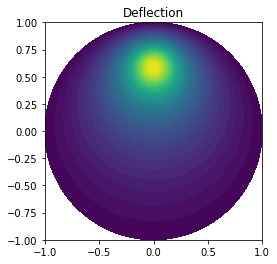

In [20]:
# Plot solution
plot(w, title='Deflection');

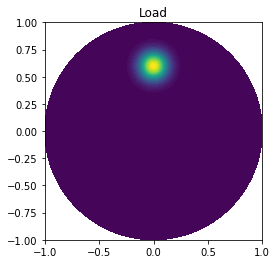

In [21]:
p = interpolate(p, V)
plot(p, title='Load');

In [22]:
vtkfile_w = File('files/poisson_membrane/deflection.pvd')
vtkfile_w << w
vtkfile_p = File('files/poisson_membrane/load.pvd')
vtkfile_p << p

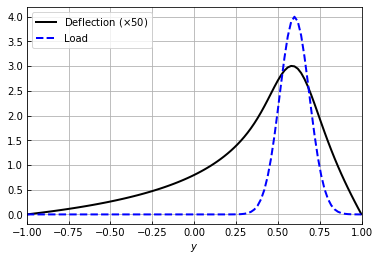

In [23]:
# Curve plot along x = 0 comparing p and w

tol = 0.001  # avoid hitting points outside the domain

y = np.linspace(-1 + tol, 1 - tol, 101)

points = [(0, y_) for y_ in y]  # 2D points

w_line = np.array([w(point) for point in points])
p_line = np.array([p(point) for point in points])

plt.plot(y, 50*w_line, 'k', linewidth=2)  # magnify w
plt.plot(y, p_line, 'b--', linewidth=2)
plt.grid(True)
plt.xlim(-1.0, 1.0)
plt.xlabel('$y$')
plt.legend(['Deflection ($\\times 50$)', 'Load'], loc='upper left')
plt.tick_params(which='both', direction='in')

# Hold plots
plt.show()

![Paraview_membrane_delflection](./figs/possion_membrane_deflection.png)